In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Bidirectional, LSTM, BatchNormalization, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds

import numpy as np
from matplotlib import pyplot as plt

print(tf.__version__)

2.2.0


In [0]:
# Loading the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [0]:
# Prepping the data a little
x_train, y_train, x_test, y_test = [], [], [], []

for x in ds_train:
  text = str(x[0].numpy()).split("b", 1)[1][1:-1]
  label = x[1].numpy()
  x_train.append(text)
  y_train.append(label)

for x in ds_test:
  text = str(x[0].numpy()).split("b", 1)[1][1:-1]
  label = x[1].numpy()
  x_test.append(text)
  y_test.append(label)

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

print(x_train.shape, y_train.shape)

(25000,) (25000,)


In [0]:
vocab_size = 80000

tokenizer = Tokenizer(num_words = vocab_size, lower = True, oov_token = '<OOV>')
tokenizer.fit_on_texts(x_train)


In [0]:
maxlen = 100
padding = 'post'
truncating = 'post'

sequences = tokenizer.texts_to_sequences(x_train)
seq_train = pad_sequences(sequences, maxlen = maxlen, padding = padding, truncating = truncating)

test_sequences = tokenizer.texts_to_sequences(x_test)
seq_test = pad_sequences(test_sequences, maxlen = maxlen, padding = padding, truncating = truncating)

In [0]:
embedding_dim = 300

model = Sequential([
                    Embedding(input_dim = vocab_size+1, output_dim= embedding_dim, input_length = maxlen),
                    LSTM(64, kernel_regularizer=regularizers.l2(0.001), return_sequences=True),
                    Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.001), return_sequences=True)),
                    Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.001))), 
                    Dense(64, activation = 'relu', kernel_regularizer='l2'),
                    Dropout(0.6),
                    Dense(32, activation = 'relu', kernel_regularizer='l2'),
                    Dropout(0.6),
                    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          24000300  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 64)           93440     
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [0]:
history = model.fit(seq_train, y_train, epochs = 50, validation_data = (seq_test, y_test), batch_size = 10000, verbose = 1)

Epoch 1/50
3/3 [==============================] - 5s 2s/step - loss: 2.7458 - accuracy: 0.5020 - val_loss: 2.6604 - val_accuracy: 0.5004
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 2.6302 - accuracy: 0.5081 - val_loss: 2.5481 - val_accuracy: 0.5425
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 2.5190 - accuracy: 0.5115 - val_loss: 2.4405 - val_accuracy: 0.5536
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 2.4124 - accuracy: 0.5326 - val_loss: 2.3369 - val_accuracy: 0.5776
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 2.3098 - accuracy: 0.5592 - val_loss: 2.2352 - val_accuracy: 0.6201
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 2.2082 - accuracy: 0.5932 - val_loss: 2.1288 - val_accuracy: 0.6728
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 2.0985 - accuracy: 0.6309 - val_loss: 2.0034 - val_accuracy: 0.6975
Epoch 8/50
3/3 [=========================

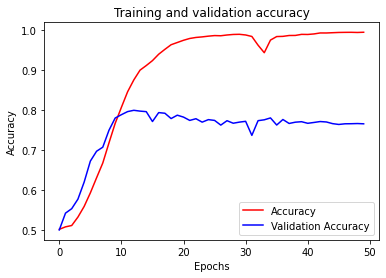

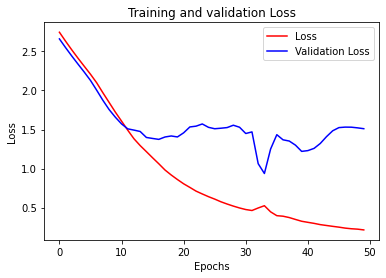

In [0]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [0]:
# Extracting the Embeddings
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(80001, 300)


In [0]:
word_index = {e:i for e,i in tokenizer.word_index.items() if i <= vocab_size}

In [0]:
# Saving the weights
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word in word_index:
  vec = weights[ int(word_index[word]) - 1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
# Downloading the weights

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')